# 彩色空间转换

In [2]:
import numpy as np
import cupy as cp
import scipy as sp
import skimage as ski
import skimage.io as skio
import skimage.color as skc
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
src1 = skio.imread('../../datas/f2.jpg')
src2 = skio.imread('../../datas/f1.jpg')

## 1. RGB图像转换灰度图像

In [4]:
def rgb2gray(src):
    assert len(src.shape) > 2
#     shape = src.shape
    src_gpu = cp.array(src.astype(np.float32))
    dst_gpu = cp.dot(src_gpu[...,:3],cp.array([0.299, 0.587, 0.114]))
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [5]:
dst = rgb2gray(src1)

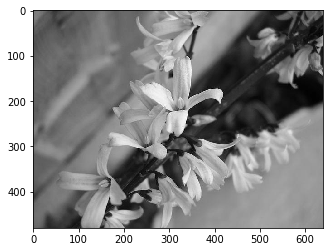

In [6]:
plt.imshow(dst,'gray')

In [7]:
def rgb2gray_avg(src):
    assert len(src.shape) > 2
    src_gpu = cp.array(src.astype(np.float32))
    src_gpu_r = src_gpu[:,:,0]
    src_gpu_g = src_gpu[:,:,1]
    src_gpu_b = src_gpu[:,:,2]
    dst_gpu = (src_gpu_r + src_gpu_g + src_gpu_b) / 3.0
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [8]:
dst = rgb2gray_avg(src1)

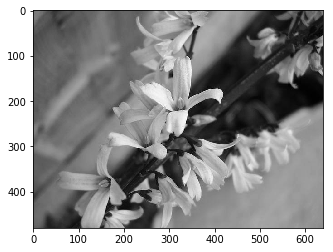

In [9]:
plt.imshow(dst,'gray')

## 2.RGB转换XYZ

In [10]:
def rgb2xyz(src):
    assert len(src.shape) > 2
    src_gpu = cp.array(src.astype(np.int32))
    R_gpu = src_gpu[:,:,0]
    G_gpu = src_gpu[:,:,1]
    B_gpu = src_gpu[:,:,2]
    X = (R_gpu * 199049 + G_gpu * 394494 + B_gpu * 455033 + 524288) >> 20
    Y = (R_gpu * 75675 + G_gpu * 749900 + B_gpu * 223002 + 524288) >> 20
    Z = (R_gpu * 915161 + G_gpu * 114795 + B_gpu * 18621 + 524288) >> 20
    dst_gpu = cp.zeros_like(src_gpu)
    dst_gpu[:,:,0] = X
    dst_gpu[:,:,1] = Y
    dst_gpu[:,:,2] = Z
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [11]:
dst = rgb2xyz(src1)

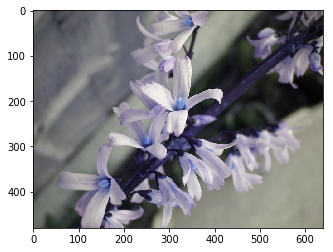

In [12]:
plt.imshow(dst)

In [13]:
def xyz2rgb(xyz):
    assert len(xyz.shape) > 2
    xyz_gpu = cp.array(xyz.astype(np.int32))
    X_gpu = xyz_gpu[:,:,0]
    Y_gpu = xyz_gpu[:,:,1]
    Z_gpu = xyz_gpu[:,:,2]
    R_gpu = (X_gpu * 55460 - Y_gpu * 213955 + Z_gpu * 1207070) >> 20  
    G_gpu = (X_gpu * -965985 + Y_gpu * 1967119 + Z_gpu * 47442) >> 20            # x * -965985 和 -x * 965985 在反汇编后是不一样的，后者多了个neg指令  
    B_gpu = (X_gpu * 3229543 - Y_gpu * 1611819 - Z_gpu * 569148) >> 20  
    
    dst_gpu = cp.zeros_like(xyz_gpu)
    dst_gpu[:,:,0] = R_gpu
    dst_gpu[:,:,1] = G_gpu
    dst_gpu[:,:,2] = B_gpu
    
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [14]:
dst = xyz2rgb(dst)

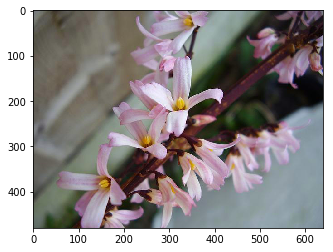

In [15]:
plt.imshow(dst)

## RGB转YCbCr

In [16]:
YCbCrYRF = 0.299      # RGB转YCbCr的系数(浮点类型）
YCbCrYGF = 0.587
YCbCrYBF = 0.114
YCbCrCbRF = -0.168736
YCbCrCbGF = -0.331264
YCbCrCbBF = 0.500000
YCbCrCrRF = 0.500000
YCbCrCrGF = -0.418688
YCbCrCrBF = -0.081312

RGBRYF = 1.00000    # YCbCr转RGB的系数(浮点类型）
RGBRCbF = 0.0000
RGBRCrF = 1.40200
RGBGYF = 1.00000  
RGBGCbF = -0.34414
RGBGCrF = -0.71414
RGBBYF = 1.00000  
RGBBCbF = 1.77200
RGBBCrF = 0.00000 

Shift = 20
HalfShiftValue = 1 << (Shift - 1)

YCbCrYRI = int((YCbCrYRF * (1 << Shift) + 0.5)) # RGB转YCbCr的系数(整数类型）
YCbCrYGI = int((YCbCrYGF * (1 << Shift) + 0.5))
YCbCrYBI = int((YCbCrYBF * (1 << Shift) + 0.5))
YCbCrCbRI = int((YCbCrCbRF * (1 << Shift) + 0.5))
YCbCrCbGI = int((YCbCrCbGF * (1 << Shift) + 0.5))
YCbCrCbBI = int((YCbCrCbBF * (1 << Shift) + 0.5))
YCbCrCrRI = int((YCbCrCrRF * (1 << Shift) + 0.5))
YCbCrCrGI = int((YCbCrCrGF * (1 << Shift) + 0.5))
YCbCrCrBI = int((YCbCrCrBF * (1 << Shift) + 0.5))

RGBRYI = int((RGBRYF * (1 << Shift) + 0.5))      # YCbCr转RGB的系数(整数类型）
RGBRCbI = int((RGBRCbF * (1 << Shift) + 0.5))
RGBRCrI = int((RGBRCrF * (1 << Shift) + 0.5))
RGBGYI = int((RGBGYF * (1 << Shift) + 0.5))
RGBGCbI = int((RGBGCbF * (1 << Shift) + 0.5))
RGBGCrI = int((RGBGCrF * (1 << Shift) + 0.5))
RGBBYI = int((RGBBYF * (1 << Shift) + 0.5))
RGBBCbI = int((RGBBCbF * (1 << Shift) + 0.5))
RGBBCrI = int((RGBBCrF * (1 << Shift) + 0.5)) 

In [17]:
def rgb2ycrcb(src):
    assert len(src.shape) > 2
    src_gpu = cp.array(src.astype(np.int32))
    Red_gpu = src_gpu[:,:,0]
    Green_gpu = src_gpu[:,:,1]
    Blue_gpu = src_gpu[:,:,2]
    Y = (YCbCrYRI * Red_gpu + YCbCrYGI * Green_gpu + YCbCrYBI * Blue_gpu + HalfShiftValue) >> Shift
    Cb = ( 128 + ( (YCbCrCbRI * Red_gpu + YCbCrCbGI * Green_gpu + YCbCrCbBI * Blue_gpu + HalfShiftValue) >> Shift))
    Cr = (128+( (YCbCrCrRI * Red_gpu + YCbCrCrGI * Green_gpu + YCbCrCrBI * Blue_gpu + HalfShiftValue) >> Shift))
    dst_gpu = cp.zeros_like(src_gpu)
    dst_gpu[:,:,0] = Y
    dst_gpu[:,:,1] = Cb
    dst_gpu[:,:,2] = Cr
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [18]:
dst = rgb2ycrcb(src1)

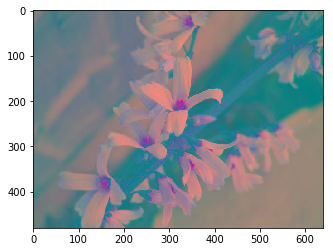

In [19]:
plt.imshow(dst)

In [22]:
def ycrcb2rgb(src):
    assert len(src.shape) > 2
    src_gpu = cp.array(src.astype(np.int32))
    Y_gpu = src_gpu[:,:,0]
    Cb_gpu = src_gpu[:,:,1] - 128
    Cr_gpu = src_gpu[:,:,2] - 128
    
    Red_gpu = Y_gpu + ((RGBRCrI * Cr_gpu + HalfShiftValue) >> Shift)
    Green_gpu = Y_gpu + ((RGBGCbI * Cb_gpu + RGBGCrI * Cr_gpu+ HalfShiftValue) >> Shift)
    Blue_gpu = Y_gpu + ((RGBBCbI * Cb_gpu + HalfShiftValue) >> Shift)
    
    dst_gpu = cp.zeros_like(src_gpu)
    dst_gpu[:,:,0] = Red_gpu
    dst_gpu[:,:,1] = Green_gpu
    dst_gpu[:,:,2] = Blue_gpu
    
    dst = dst_gpu.get()
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [23]:
dst = ycrcb2rgb(dst)

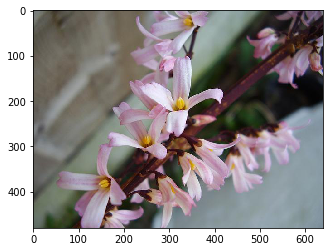

In [24]:
plt.imshow(dst)